# Brain Tumor Detection

In the following notebook, we aims to develop a Convolutional Neural Network (CNN) using the PyTorch framework that can accurately detect and classify Brain Tumors from MRI scans. The CNN will be trained on a large dataset of labeled brain tumor images to learn the patterns and features associated with different tumor types.

## <b>1 <span style='color:#e61227'>|</span> reuirements and libraries</b>



In [1]:
!pip install split-folders
!pip install torch-summary

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
import splitfolders
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import classification_report
import itertools
from tqdm.notebook import trange, tqdm
from torch import optim
import warnings
warnings.filterwarnings('ignore')

## <b>2 <span style='color:#e61227'>|</span> Dataset</b>

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>2.1 |</span></b> Download and load Dataset</b></p>
</div>

In [3]:
! gdown 1hwV1mcc-Bm_AY_t_FG8byxKFmhY4uGsh
! unzip brain.zip

Downloading...
From (original): https://drive.google.com/uc?id=1hwV1mcc-Bm_AY_t_FG8byxKFmhY4uGsh
From (redirected): https://drive.google.com/uc?id=1hwV1mcc-Bm_AY_t_FG8byxKFmhY4uGsh&confirm=t&uuid=2303b3d1-72a7-4980-9b02-199bf3cb3841
To: /content/brain.zip
100% 111M/111M [00:01<00:00, 60.7MB/s]
Archive:  brain.zip
   creating: brain/
   creating: brain/val/
   creating: brain/val/Healthy/
  inflating: brain/val/Healthy/Not Cancer  (710).jpg  
  inflating: brain/val/Healthy/Not Cancer  (1600).jpg  
  inflating: brain/val/Healthy/Not Cancer  (1008).jpg  
  inflating: brain/val/Healthy/Not Cancer  (45).jpg  
  inflating: brain/val/Healthy/Not Cancer  (1208).jpg  
  inflating: brain/val/Healthy/Not Cancer  (1069).jpg  
  inflating: brain/val/Healthy/Not Cancer  (11).jpg  
  inflating: brain/val/Healthy/Not Cancer  (1823).jpg  
  inflating: brain/val/Healthy/Not Cancer  (111).jpg  
  inflating: brain/val/Healthy/Not Cancer  (115).jpg  
  inflating: brain/val/Healthy/Not Cancer  (1615).jpg  


## <b>3 <span style='color:#e61227'>|</span> Data Preparation </b>

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>3.1 |</span></b> Splitting Dataset</b></p>
</div>

- We need to evaluate the model on validation datasets to track the model's performance during training. Then, We use 20% of the dataset for the **Validation set** and use the rest as the **Training set**, so we have an **80/20** split!

In [4]:
# Dataset Path
data_dir = '/content/brain'
data_dir = pathlib.Path(data_dir)

In [15]:
# define transformation
# transform images to (256, 256) and normalize them
transform = transforms.Compose(
    [
      transforms.Resize(size=(256, 256)),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomVerticalFlip(p=0.5),
      transforms.RandomRotation(degrees=[-30.0, 30.0], expand=False, fill=0),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

## <b>4 <span style='color:#e61227'>|</span> Image Augmentation Definitions</b>

In [16]:
# Define an object of the custom dataset for the train and validation.
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform=transform)
train_set.transform
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform)
val_set.transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

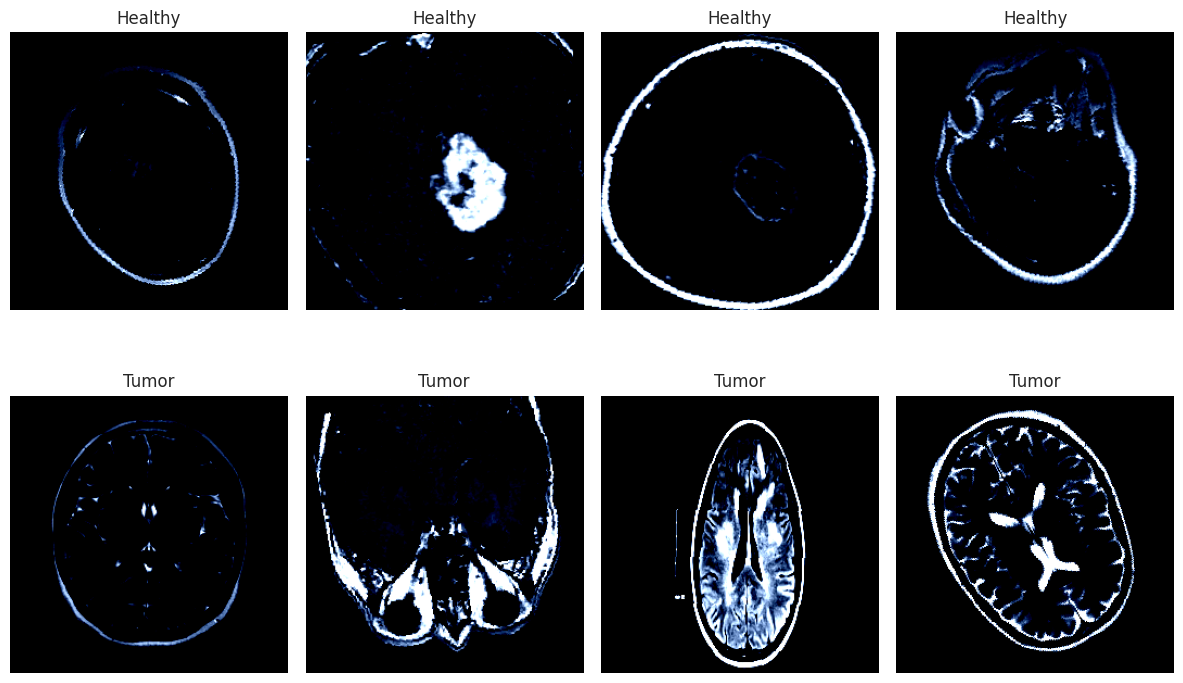

In [17]:
# Get a sample of healthy and tumor images from the training set
num_samples_per_class = 4

healthy_images = []
tumor_images = []

for image, label in train_set:
  if label == 0 and len(healthy_images) < num_samples_per_class:
    healthy_images.append(image)
  elif label == 1 and len(tumor_images) < num_samples_per_class:
    tumor_images.append(image)
  if len(healthy_images) == num_samples_per_class and len(tumor_images) == num_samples_per_class:
    break

plt.figure(figsize=(12, 8))

for i in range(num_samples_per_class):
  plt.subplot(2, num_samples_per_class, i + 1)
  plt.imshow(np.transpose(healthy_images[i], (1, 2, 0)))
  plt.title("Healthy")
  plt.axis('off')

for i in range(num_samples_per_class):
  plt.subplot(2, num_samples_per_class, i + 1 + num_samples_per_class)
  plt.imshow(np.transpose(tumor_images[i], (1, 2, 0)))
  plt.title("Tumor")
  plt.axis('off')

plt.tight_layout()
plt.show()

## <b>5 <span style='color:#e61227'>|</span> Creating Dataloaders</b>

In [18]:
# import and load train, validation
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True, num_workers = 2)


In [19]:
# print shape for Training data and Validation data
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64



## <b>6 <span style='color:#e61227'>|</span> Define Brain Tumor Classifier</b>


In [ ]:
def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [21]:
# Define any arbitrary Architecture For CNN_TUMOR Model

class CNN_TUMOR(nn.Module):

    def __init__(self, params):

        super(CNN_TUMOR, self).__init__()

        Cin, Hin, Win = params["shape_in"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(init_f, init_f*2, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(init_f*2, init_f*4, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(init_f*4*32*32, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)
        self.dropout = nn.Dropout(self.dropout_rate)

    def forward(self, X):
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        X = self.pool(F.relu(self.conv3(X)))
        X = X.view(-1, self.num_flat_features(X))
        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        X = self.fc2(X)
        return X

    def num_flat_features(self, X):
        size = X.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [23]:
# define parameters of the model
params_model = {
    "shape_in": (3, 256, 256),
    "initial_filters": 32,
    "num_fc1": 512,
    "dropout_rate": 0.5,
    "num_classes": 2
}

# Create instantiation of Network class
cnn_model = CNN_TUMOR(params_model)

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

## <b>7 <span style='color:#e61227'>|</span> Loss Function Definition</b>

In [24]:
# define the loss function

loss_func = nn.CrossEntropyLoss()

## <b>8 <span style='color:#e61227'>|</span> Optimiser Definition</b>

In [25]:
# define the optimizer

opt = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

## <b>9 <span style='color:#e61227'>|</span> Training Model</b>

In [30]:
# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None): # Add opt as an optional argument with default value None
    loss = loss_func(output, target)
    metric_b = accuracy(output, target)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None): # Add opt as an optional argument with default value None

    run_loss=0.0
    run_acc = 0.0 # Initialize run_acc to 0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)
        loss_b, acc_b = loss_batch(loss_func, output, yb, opt)
        run_loss += loss_b

        if acc_b is not None:
            run_acc += acc_b.item()

    loss = run_loss / len(dataset_dl)
    accuracy = run_acc / len(dataset_dl)


    return loss, accuracy

# Helper function to calculate accuracy
def accuracy(output, target):
    _, preds = torch.max(output, dim=1)
    return torch.tensor(torch.sum(preds == target).item() / len(preds))

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>9.2 |</span></b> Training Function</b></p>
</div>


In [28]:
def Train_Val(model, train_dl, val_dl, epochs, opt, lr_scheduler, loss_func):

    loss_history={"train": [],"val": []}
    metric_history={"train": [],"val": []}
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')

    for epoch in tqdm(range(epochs)):

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, None)
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        lr_scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch+1}/{epochs}, train loss: {train_loss:.6f}, val loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
        print("-"*10)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>9.3 |</span></b> Training Process </b></p>
</div>

In [31]:
# Define parameters used for training and evaluation of a cnn_model
epochs = 20

# train and validate the model
cnn_model,loss_hist,metric_hist = Train_Val(cnn_model, train_loader, val_loader, epochs, opt, lr_scheduler, loss_func)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, train loss: 0.907589, val loss: 0.528811, accuracy: 75.81
----------
Epoch 2/20, train loss: 0.486999, val loss: 0.412669, accuracy: 82.52
----------
Epoch 3/20, train loss: 0.380317, val loss: 0.322809, accuracy: 85.37
----------
Epoch 4/20, train loss: 0.327043, val loss: 0.293311, accuracy: 87.95
----------
Epoch 5/20, train loss: 0.294201, val loss: 0.256710, accuracy: 88.83
----------
Epoch 6/20, train loss: 0.264391, val loss: 0.247966, accuracy: 90.29
----------
Epoch 7/20, train loss: 0.229110, val loss: 0.181960, accuracy: 92.60
----------
Epoch 8/20, train loss: 0.206261, val loss: 0.215443, accuracy: 90.82
----------
Epoch 9/20, train loss: 0.187529, val loss: 0.147792, accuracy: 94.73
----------
Epoch 10/20, train loss: 0.168904, val loss: 0.134768, accuracy: 95.05
----------
Epoch 11/20, train loss: 0.149129, val loss: 0.129236, accuracy: 95.67
----------
Epoch 12/20, train loss: 0.132875, val loss: 0.132780, accuracy: 95.30
----------
Epoch 13/20, train loss: 

## <b>10 <span style='color:#e61227'>|</span> Evaluation Metric Visualization </b>

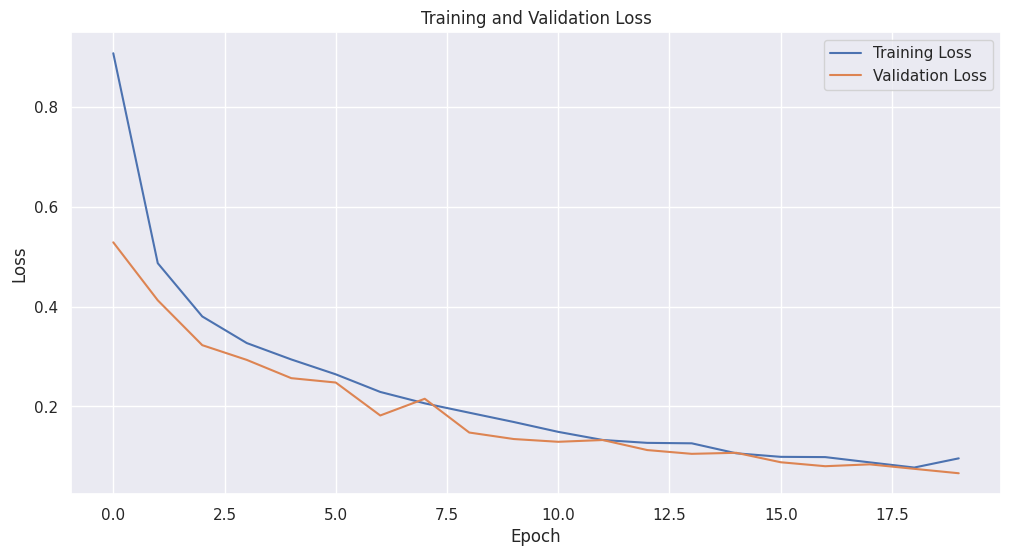

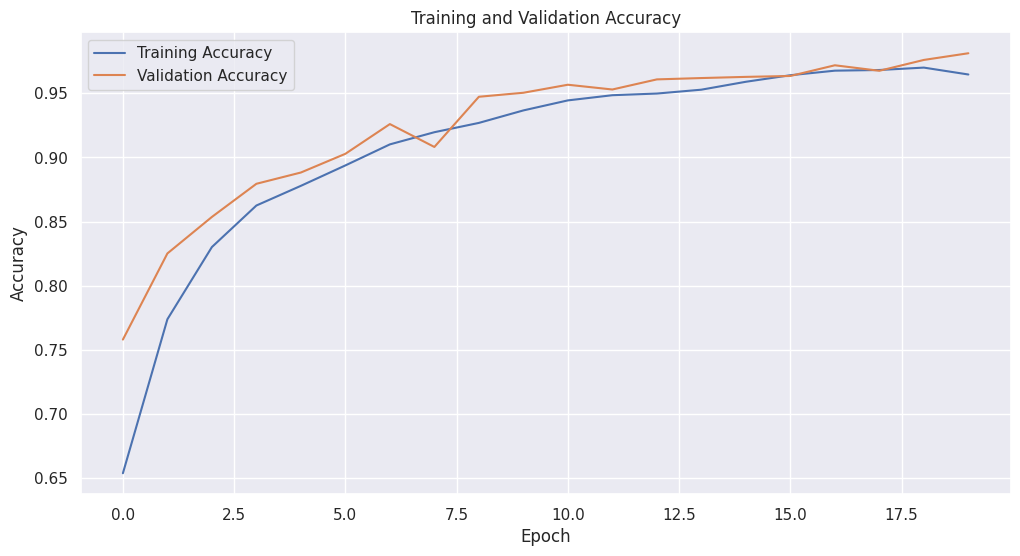

In [32]:
# Convergence History Plot
# plot the loss vlues and accuracy of your model during the training process

plt.figure(figsize=(12, 6))
plt.plot(loss_hist['train'], label='Training Loss')
plt.plot(loss_hist['val'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(metric_hist['train'], label='Training Accuracy')
plt.plot(metric_hist['val'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>10.2 |</span></b> Confusion_Matrix </b></p>
</div>

In [37]:
# define function For Classification Report
def Ture_and_Pred(val_loader, model):
    i = 0
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            output = model(xb)
            _, preds = torch.max(output, dim=1)
            y_true.extend(yb.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred


from sklearn.metrics import confusion_matrix as sk_confusion_matrix

# check confusion matrix for error analysis
y_true, y_pred = Ture_and_Pred(val_loader, cnn_model)

print(classification_report(y_true, y_pred), '\n\n')
cm = sk_confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       503
           1       0.97      0.98      0.97       418

    accuracy                           0.98       921
   macro avg       0.98      0.98      0.98       921
weighted avg       0.98      0.98      0.98       921
 




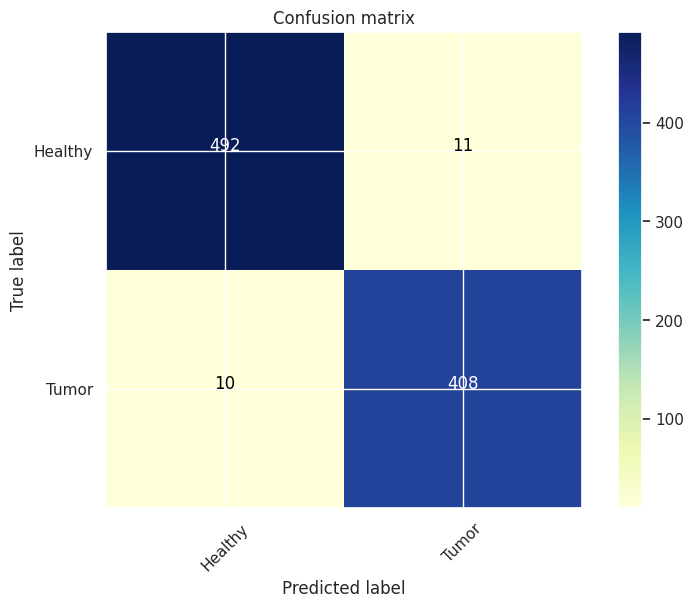

In [38]:
# Confusion Matrix Plotting Function
def show_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.YlGnBu):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(cm))
    plt.xticks(tick_marks, ["Healthy", "Tumor"], rotation=45)
    plt.yticks(tick_marks, ["Healthy", "Tumor"])

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

show_confusion_matrix(cm)